# Exercise 4a
#### Lars Kühmichel, Ergin Kohen Sagner, Nicolas Wolf

## 2 Red Cards Study

### 2.1 Loading and Cleaning the Data

#### What do the feature names stand for?

What the feature names stand for can be found in the `README.txt`.
E.g. `games` stands for "number of games in the player-referee",
i.e. how many games that player played under that referee.

#### Which irrelevant features might be dropped?
Features that are irrelevant are for example `birthday`, `height` or `weight`.
Features like `games` and `redCards` are essential to the study,
but even features like `refNum` are important to adjust
for individual referee bias.

#### What relevant features might be missing, but can be computed?


#### Are there missing data values, and how should they be dealt with?

Some features, especially skin color ratings, are occasionally missing. We will disaggregate the data to
deal with these in a simpler way.



In [357]:
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from uncertainties import ufloat
import seaborn as sns


#### Disaggregating the data

The data is more usable in a format that has each instance (line) as a single player-ref interaction.
See [this notebook](https://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb).

In [358]:
def disaggregate(filepath, out_path):
    """
    This code was copied and converted to Python 3 from disaggregate_v3.py
    Some of it is of questionable quality. Blame the original devs.
    see https://osf.io/w7tds/
    """
    dataframe = pd.read_csv(filepath)

    # add new vars
    dataframe["skintone"] = (dataframe["rater1"] + dataframe["rater2"]) / 2
    dataframe["all_reds"] = dataframe["yellowReds"] + dataframe["redCards"]
    dataframe["all_reds_strict"] = dataframe["redCards"]
    dataframe["ref_count"] = 0

    # add a column which tracks how many games each ref is involved in
    refs = pd.unique(dataframe["refNum"].values.ravel())  # list all unique ref IDs

    # for each ref, count their dyads
    print("Counting dyads")
    for r in refs:
        m = dataframe["refNum"] == r
        dataframe["ref_count"][m] = len(dataframe[m])

    colnames = list(dataframe.columns)

    print("creating out")
    j = 0
    out = [0 for _ in range(sum(dataframe["games"]))]
    for _, row in dataframe.iterrows():
        n = row["games"]
        c = row["all_reds"]
        d = row["all_reds_strict"]

        for _ in range(n):
            row["all_reds"] = 1 if (c-_) > 0 else 0
            row["all_reds_strict"] = 1 if (d-_) > 0 else 0
            rowlist = list(row)
            out[j] = rowlist
            j += 1
            if j % 10000 == 0:
                print(f"Number {j} of {dataframe.shape[0]}")

    pd.DataFrame(out, columns=colnames).to_csv(out_path, index=False)


filepath = Path("data", "dataset", "crowdstorm_disaggregated.csv")

if not filepath.is_file():
    print("Creating disaggregated dataset...")
    p = Path("data", "dataset", "CrowdstormingDataJuly1st.csv")
    disaggregate(p, filepath)

if not filepath.is_file():
    raise RuntimeError("Could not create disaggregated dataset.")

dataframe = pd.read_csv(filepath)

# show some of the dataframe
dataframe.iloc[0:6,0:13]


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0


#### Transforming categorical features to a one-hot encoding

In [359]:
def one_hot(a):
    """
    See https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-1-hot-encoded-numpy-array
    :param a: Array of categorical features (e.g. league strings)
    """
    _, i = np.unique(a, return_inverse=True)
    result = np.full((i.size, i.max() + 1), False)
    result[np.arange(i.size),i] = True

    return result

# for some reason pandas only accepts these as 2d if they are lists, not numpy arrays
dataframe.club = list(one_hot(dataframe.club.fillna("")))
dataframe.leagueCountry = list(one_hot(dataframe.leagueCountry.fillna("")))
dataframe.position = list(one_hot(dataframe.position.fillna("")))

# print some samples to show this worked
print("club")
print(dataframe.club[0])
print("leagueCountry")
print(dataframe.leagueCountry[0])
print("position")
print(dataframe.position[0])

club
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]
leagueCountry
[False False False  True]
position
[False  True False False False False False False False False False False
 False]


#### Distribution of individual ref-player dyad game numbers

See again [this notebook](https://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb#What-is-the-distribution-of-individual-ref-player-dyad-game-numbers?).

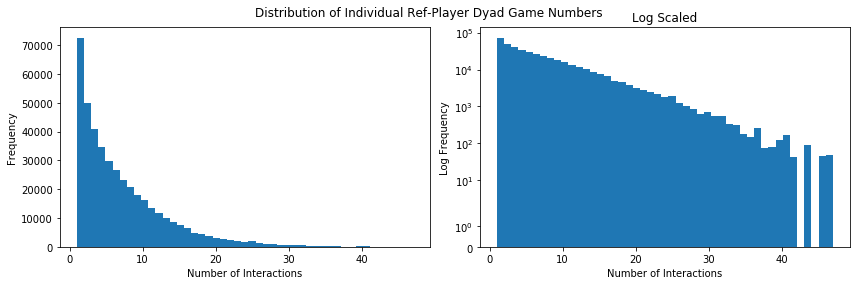

In [360]:
# distribution of individual ref-player dyad game numbers
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(dataframe.games, bins=max(dataframe.games), histtype="stepfilled")
axes[0].set_xlabel("Number of Interactions")
axes[0].set_ylabel("Frequency")

axes[1].hist(dataframe.games, bins=max(dataframe.games), histtype="stepfilled")
axes[1].set_yscale("symlog")
axes[1].set_title("Log Scaled")
axes[1].set_xlabel("Number of Interactions")
axes[1].set_ylabel("Log Frequency")

fig.suptitle("Distribution of Individual Ref-Player Dyad Game Numbers")
fig.tight_layout()
plt.show()

#### Do the Raters agree on skin colour ratings?

The raters agree with one another in $76.8\%$ of cases.
When they disagree, they still typically pick neighbouring categories.
It is therefore useful to take the mean of the two raters since they disagree relatively often.

In [361]:
rater1 = np.array(dataframe.rater1)
rater2 = np.array(dataframe.rater2)

# remove nan values. Here, it is important to remove associated dyads from both raters
mask1 = ~np.isnan(rater1)
mask2 = ~np.isnan(rater2)
mask = mask1 & mask2
rater1 = rater1[mask]
rater2 = rater2[mask]

nagree = np.sum(rater1 == rater2)
diff = rater1 - rater2

print(f"Number of times raters agree: {nagree}")
print(f"Number of times raters disagree: {len(diff) - nagree}")
print(f"Raters agree in {100 * nagree / len(diff):.2f}% of cases.")

_df = pd.DataFrame(pd.Series(diff).value_counts(), columns=["Counts"])
_df.index.name = "Difference"

_df

Number of times raters agree: 287928
Number of times raters disagree: 85139
Raters agree in 77.18% of cases.


,Counts
Difference,
0.00,287928
-0.25,70124
0.25,14576
-0.50,439


#### Comparison of Raters

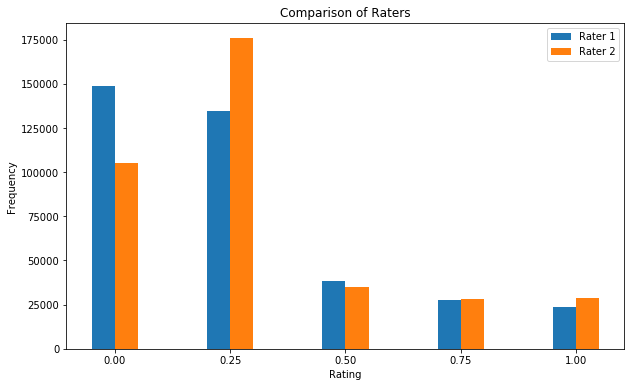

In [362]:
# bar charts are slow (because they need np.unique counts),
# so we will use a hack to generate something equivalent
values = np.array([0.0, 0.25, 0.50, 0.75, 1.0])
width = 0.05
epsilon = 0.000001

bins1 = np.array(list(zip(values - width, values + epsilon))).flatten()
bins2 = np.array(list(zip(values - epsilon, values + width))).flatten()

plt.figure(figsize=(10, 6))
plt.hist(dataframe.rater1, bins=bins1, label="Rater 1")
plt.hist(dataframe.rater2, bins=bins2, label="Rater 2")
plt.xticks(values)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend()
plt.title("Comparison of Raters")
plt.show()

#### Where do raters disagree most?

From the plots it is evident that the two raters disagree most on lighter skin colors. The most common case
where they disagree has Rater 1 select the skintone as "Very Light" $(0.0)$ and Rater 2 as "Light" $(0.25)$.

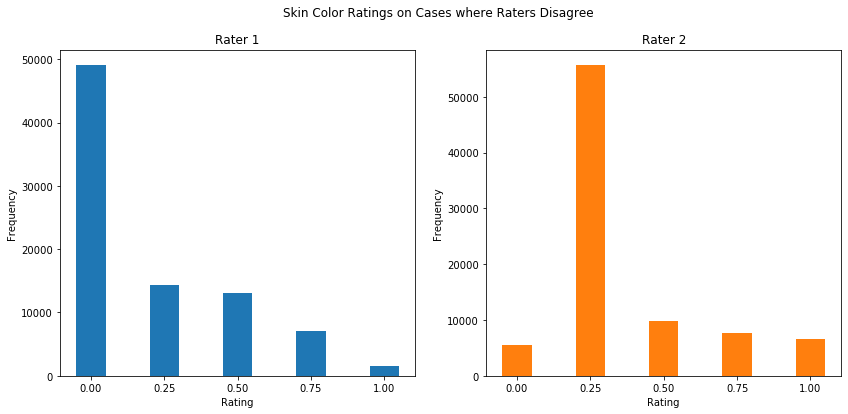

rater2,0.00,0.25,0.50,0.75,1.00
rater1,,,,,
0.00,99636,48621,439,0,0
0.25,5516,120135,8880,0,0
0.50,0,7056,25415,6045,0
0.75,0,0,448,20800,6578
1.00,0,0,0,1556,21942


In [363]:
mask = rater1 != rater2

r1d = rater1[mask]
r2d = rater2[mask]

bins = np.array(list(zip(values - width, values + width))).flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].hist(r1d, bins=bins, color="C0")
axes[0].set_title("Rater 1")
axes[0].set_xticks(values)
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Frequency")
axes[1].hist(r2d, bins=bins, color="C1")
axes[1].set_title("Rater 2")
axes[1].set_xticks(values)
axes[1].set_xlabel("Rating")
axes[1].set_ylabel("Frequency")
fig.suptitle("Skin Color Ratings on Cases where Raters Disagree")

plt.show()

pd.crosstab(dataframe["rater1"], dataframe["rater2"])


#### Should Referees with very few appearances be excluded from the dataset?

Since we disagreggated the data, an "appearance" is now a single dyad.
Excluding referees with few appearances is generally a good idea,
if we have enough referees with many appearances,
such as to not skew the dataset through outliers. [This notebook](https://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb#We-clean-the-data-by-excluding-interactions-by-refs-who-feature-in-fewer-than-22-dyads)
mentions that referees with fewer than 22 appearances did not play in
one of the major leagues we are interested in, and should thus be removed.

#### What does the distribution of ref occurance look like?

See again [this notebook](https://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb#And-what-does-the-distribution-of-ref-occurance-look-like?).

Total number of referees = 3147
Median number of dyads per referee = 11.0


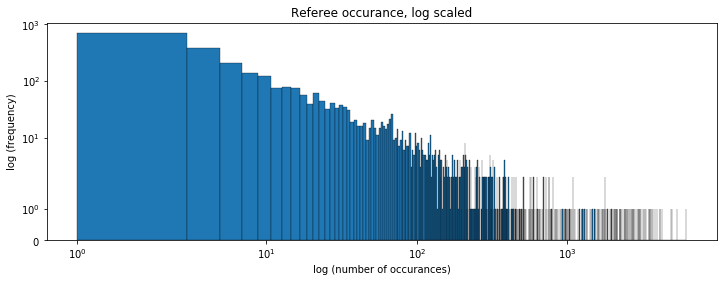

In [364]:
all_refs = dataframe.refNum.value_counts()

num_refs = len(all_refs)
print("Total number of referees =", num_refs)
print("Median number of dyads per referee =", np.median(dataframe.refNum.value_counts()))

_, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
axes.hist(dataframe.refNum.value_counts().tolist(), bins=num_refs, edgecolor="black", linewidth=0.3)
axes.set_xscale("symlog") # symetric log scale
axes.set_yscale("symlog")
axes.set_title("Referee occurance, log scaled")
axes.set_xlabel("log (number of occurances)")
axes.set_ylabel("log (frequency)")

plt.show()


#### We clean the data by excluding interactions by refs who feature in fewer than 22 dyads

See again [this notebook](https://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb#We-clean-the-data-by-excluding-interactions-by-refs-who-feature-in-fewer-than-22-dyads).

We keep only about $40\%$ of referees, but more than $97\%$ of dyads.

Referees kept: 1261 out of 3147 (40.07%)
Dyads kept: 415692 out of 426572 (97.45%)


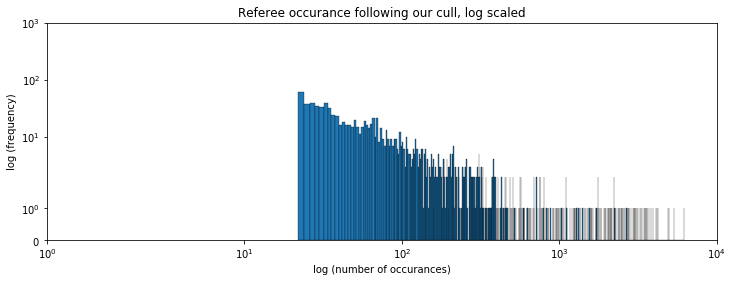

In [365]:
good_refs = all_refs[all_refs>21]

print(f"Referees kept: {len(good_refs)} out of {len(all_refs)} ({100 * len(good_refs) / len(all_refs):.2f}%)")
print(f"Dyads kept: {sum(good_refs)} out of {sum(all_refs)} ({100 * sum(good_refs) / sum(all_refs):.2f}%)")

_, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
axes.hist(good_refs.tolist(), num_refs-11, edgecolor="black", linewidth=0.3)
axes.set_xscale("symlog") # symetric log scale
plt.xlim([1,10000])
axes.set_yscale("symlog")
plt.ylim([0,1000])
axes.set_title("Referee occurance following our cull, log scaled")
axes.set_xlabel("log (number of occurances)")
axes.set_ylabel("log (frequency)")

plt.show()

#### Should features be normalized and/or centralized?

Centralizing the data is useful for linear regression.


### 2.2 Model Creation

#### Linear Regression

(array([ 1.74817138e-03, -9.77437203e-05, -2.63190521e-05,  9.76092608e-05]), 0.005873263427821022)


c:\program files\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\program files\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\program files\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\program files\py

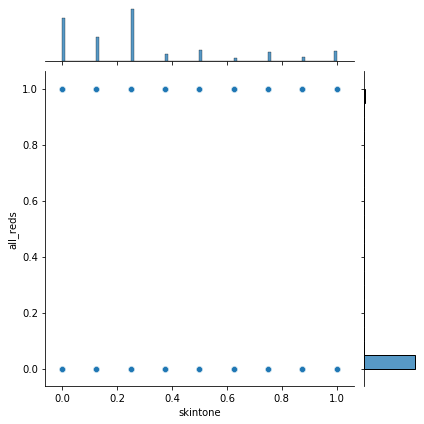

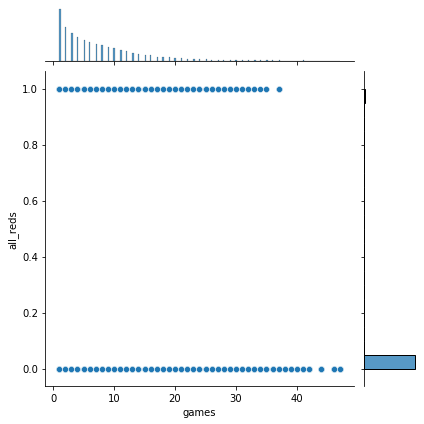

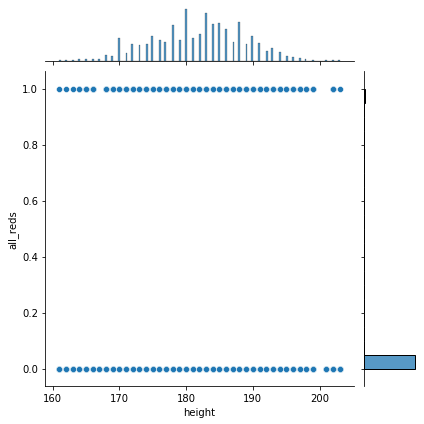

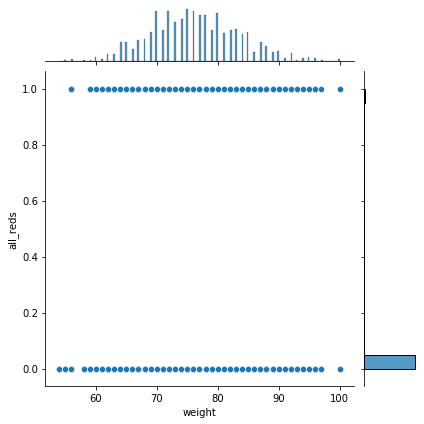

In [366]:
class LinearRegressor:
    def __init__(self, x, y):
        self.x = x
        self.y = y

        self.beta = None
        self.b = None

    def func(self, x):
        if self.beta is None or self.b is None:
            raise RuntimeError("Attempted to use regressor weights without fitting.")
        return self.beta * x + self.b

    def fit(self, assume_centralized=False):
        if not assume_centralized:
            mx, my = self.centralize()
        else:
            mx, my = 0, 0

        if self.x.ndim > 1:
            self.beta = np.linalg.pinv(self.x) @ self.y
            self.b = my - self.beta @ mx
        else:
            self.beta = np.dot(self.x, self.y) / np.sum(np.square(self.x))
            self.b = my - self.beta * mx

        return self.beta, self.b

    def centralize(self):
        mx = np.mean(self.x, axis=0)
        my = np.mean(self.y, axis=0)
        self.x = self.x - mx
        self.y = self.y - my
        return mx, my

x = pd.concat([dataframe.skintone, dataframe.games, dataframe.height, dataframe.weight], axis=1)
# x = dataframe.skintone
y = dataframe.all_reds

mask1 = np.all(~np.isnan(x), axis=1)
# mask1 = ~np.isnan(x)
mask2 = ~np.isnan(y)
mask = mask1 & mask2

x = x[mask]
y = y[mask]

lr = LinearRegressor(x, y)

popt = lr.fit()

print(popt)

for i in range(x.shape[1]):
    sns.jointplot(x.iloc[:,i], y)
    plt.show()


#### Regression Forest